In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import yfinance as yf
warnings.filterwarnings('ignore')


Data Collection and Visualization

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


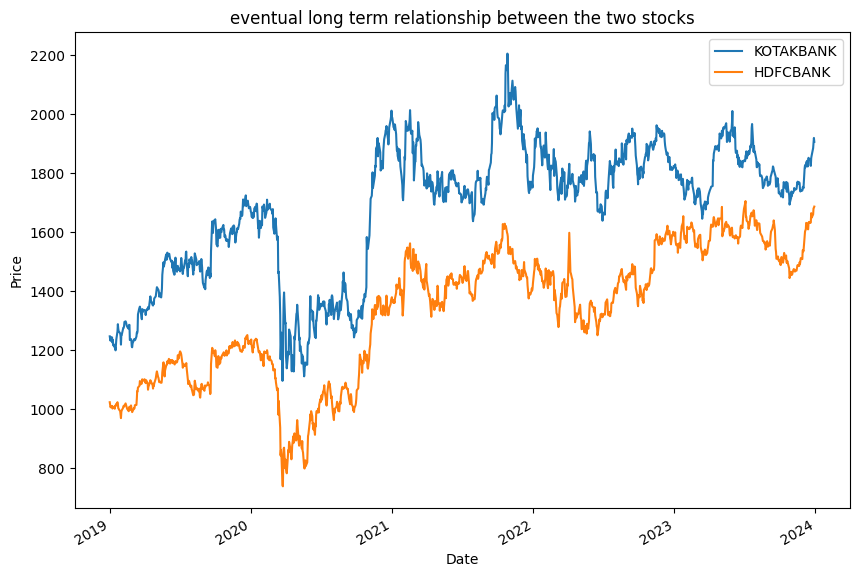

         KOTAKBANK     HDFCBANK
count  1235.000000  1235.000000
mean   1680.212386  1329.926665
std     230.330850   220.177916
min    1094.941895   736.975586
25%    1501.781555  1151.518311
50%    1747.719482  1379.578369
75%    1846.447327  1507.168945
max    2205.384521  1704.918579


In [3]:
enddate='2023-12-31'
startdate='2019-1-1'
x=yf.download('KOTAKBANK.NS',start=startdate,end=enddate)['Adj Close']
y=yf.download('HDFCBANK.NS',start=startdate,end=enddate)['Adj Close']
df=pd.concat([x,y],axis=1)
df.columns=['KOTAKBANK','HDFCBANK']
df.plot(figsize=(10,7))
plt.ylabel('Price')
plt.title('eventual long term relationship between the two stocks')
plt.show()
print(df[['KOTAKBANK', 'HDFCBANK']].describe())  # Check if the asset price columns are populated



In [4]:
correlation = df['KOTAKBANK'].corr(df['HDFCBANK'])
print(f"Correlation between assets: {correlation}")


Correlation between assets: 0.8883323777156574


 Hedge Ratio Calculation Using Linear Regression

In [5]:
#Performing linear regression btwn the two stocks to calculate the hedge ration
X=df['KOTAKBANK']
y=df['HDFCBANK']
model=np.polyfit(X,y,deg=1)
hedge_ratio=model[0]
hr=round(hedge_ratio,3)
print(f'the hedge ratio is {hr}')

the hedge ratio is 0.849


Spread Calculation

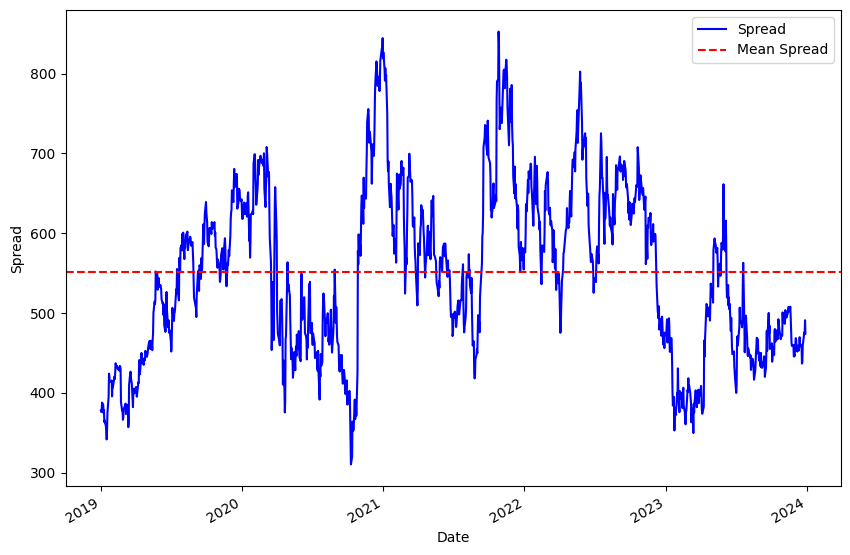

In [6]:
# Calculating the spread
df['Spread']= df.KOTAKBANK - hr *df.HDFCBANK
# Plotting the spread 
df.Spread.plot(figsize=(10,7),color='b')
plt.axhline(df.Spread.mean(), color='red',linestyle='--',label='Mean Spread')
plt.ylabel('Spread')
plt.legend()
plt.show()

Cointegration test using Augmented Dickey-Fuller

In [7]:
from statsmodels.tsa.stattools import adfuller
adf_result=adfuller(df.Spread,maxlag=1)
print('ADF Statistics:', adf_result[0])
print('p-value :',adf_result[1])
print('Criical Values:',adf_result[4])
if adf_result[1]<0.05 :
    print('The spread series is likely stationary')
else :
     print('The spread series is likely not stationary')  




ADF Statistics: -3.9177280102633345
p-value : 0.0019081840338695485
Criical Values: {'1%': -3.435660336370594, '5%': -2.863885022214541, '10%': -2.568018522153254}
The spread series is likely stationary


Simple Mean Reversion strategy

Rolling stats (first 30 rows):
             moving_average  moving_std_dev  upper_band  lower_band
Date                                                              
2019-01-01             NaN             NaN         NaN         NaN
2019-01-02             NaN             NaN         NaN         NaN
2019-01-03             NaN             NaN         NaN         NaN
2019-01-04             NaN             NaN         NaN         NaN
2019-01-07             NaN             NaN         NaN         NaN
2019-01-08             NaN             NaN         NaN         NaN
2019-01-09             NaN             NaN         NaN         NaN
2019-01-10             NaN             NaN         NaN         NaN
2019-01-11             NaN             NaN         NaN         NaN
2019-01-14             NaN             NaN         NaN         NaN
2019-01-15             NaN             NaN         NaN         NaN
2019-01-16             NaN             NaN         NaN         NaN
2019-01-17             NaN    

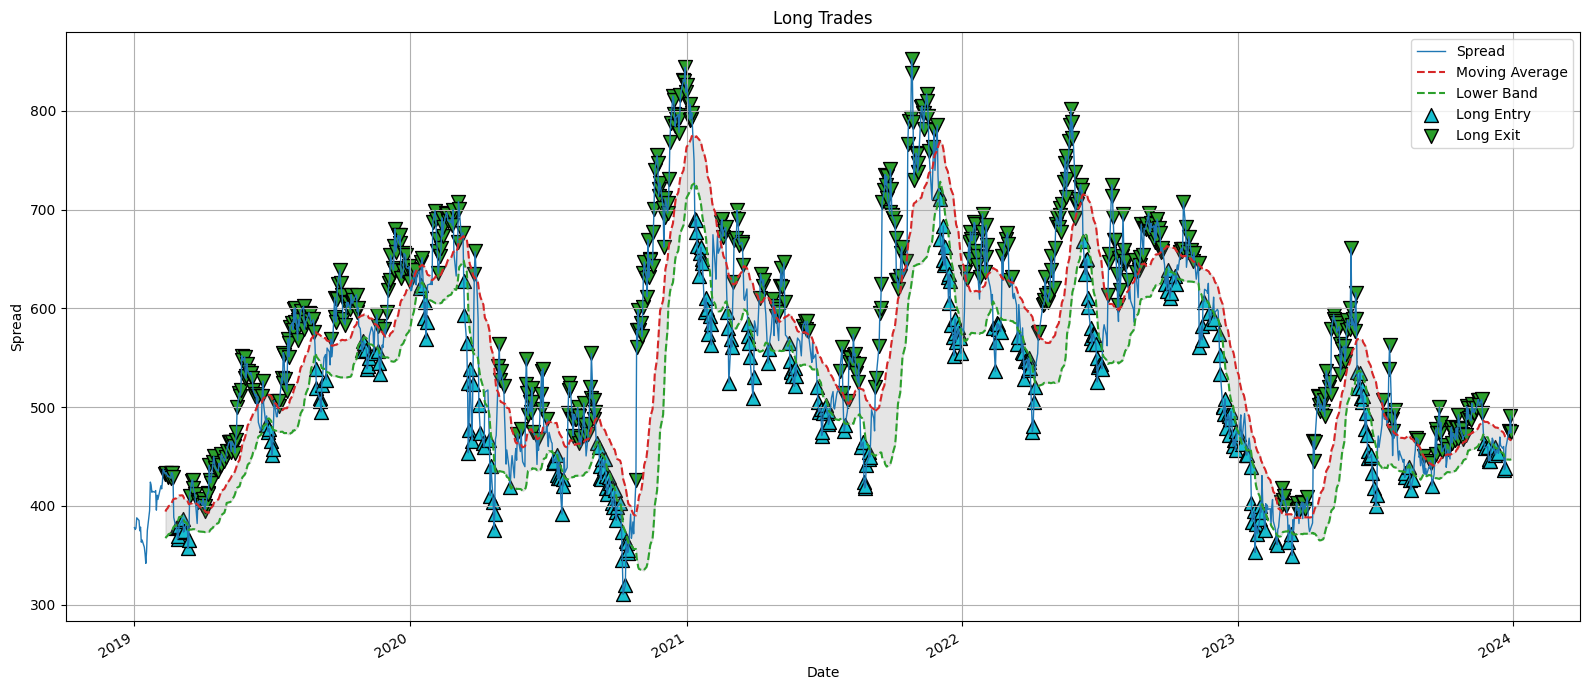

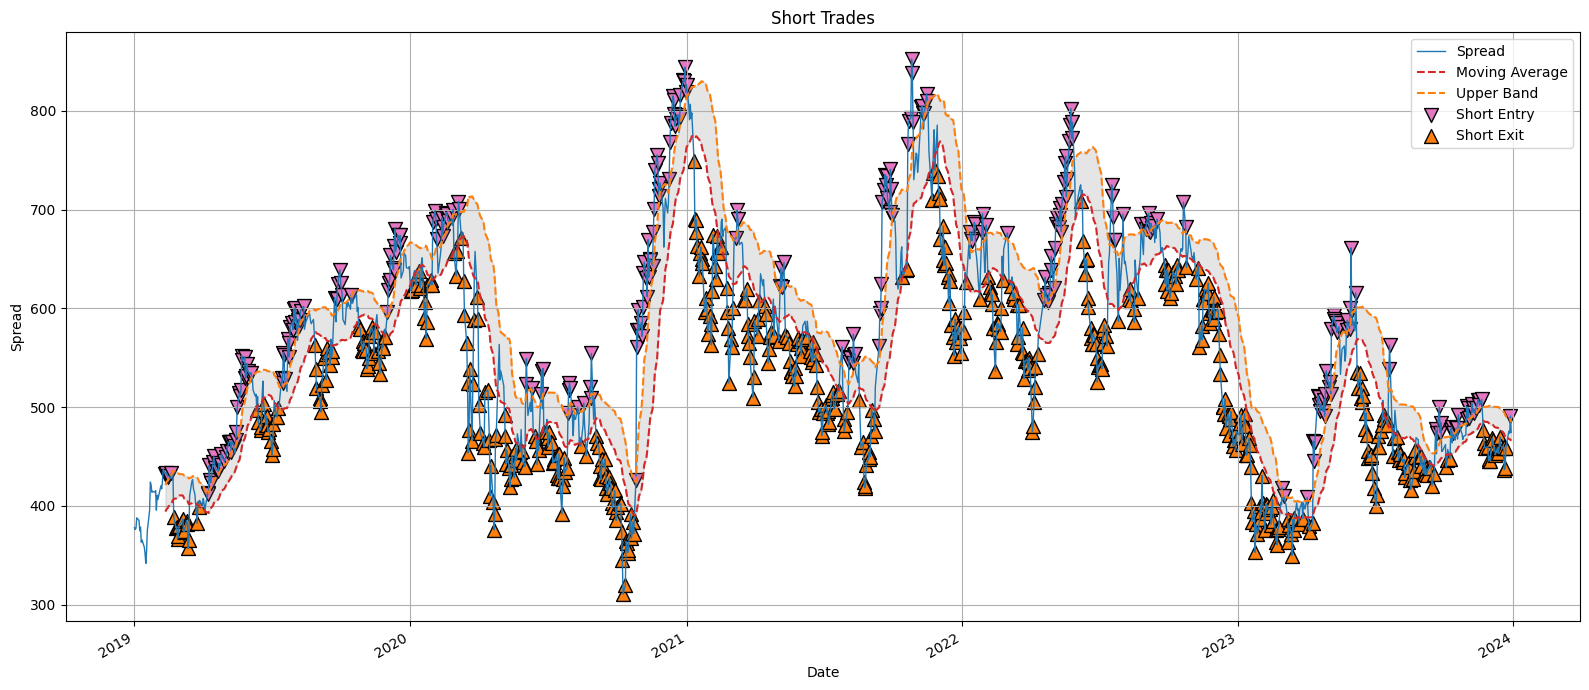

In [12]:


def mean_reversion_strategy(df, period=30, std_dev=1):
    # Calculate rolling statistics (moving average, std dev, upper and lower bands)
    df['moving_average'] = df['Spread'].rolling(period).mean()
    df['moving_std_dev'] = df['Spread'].rolling(period).std()
    df['upper_band'] = df['moving_average'] + std_dev * df['moving_std_dev']
    df['lower_band'] = df['moving_average'] - std_dev * df['moving_std_dev']

    # Generate entry/exit signals
    df['long_entry'] = (df['Spread'] < df['lower_band'])
    df['long_exit'] = (df['Spread'] >= df['moving_average'])
    df['short_entry'] = (df['Spread'] > df['upper_band'])
    df['short_exit'] = (df['Spread'] <= df['moving_average'])

    # Generate positions based on signals
    df['positions_long'] = np.nan
    df.loc[df['long_entry'], 'positions_long'] = 1
    df.loc[df['long_exit'], 'positions_long'] = 0
    df['positions_long'] = df['positions_long'].fillna(method='ffill')

    df['positions_short'] = np.nan
    df.loc[df['short_entry'], 'positions_short'] = -1
    df.loc[df['short_exit'], 'positions_short'] = 0
    df['positions_short'] = df['positions_short'].fillna(method='ffill')

    # Combine long and short positions
    df['positions'] = df['positions_long'].fillna(0) + df['positions_short'].fillna(0)

    # Print information for debugging
    print("Rolling stats (first 30 rows):\n", df[['moving_average', 'moving_std_dev', 'upper_band', 'lower_band']].head(30))
    print("Number of long/short entry and exit signals:\n", df[['long_entry', 'long_exit', 'short_entry', 'short_exit']].sum())
    print("Entry signals (first 30 rows):\n", df[['long_entry', 'short_entry']].head(30))
    print("Positions (last 30 rows):\n", df[['positions_long', 'positions_short', 'positions']].tail(30))

    return df

df = mean_reversion_strategy(df, period=30, std_dev=1)

# Plot functions for long and short trades
def plot_long_trades(df):
    plt.figure(figsize=(16, 7))
    df['Spread'].plot(label='Spread', color='#1f77b4', linewidth=1)
    df['moving_average'].plot(label='Moving Average', color='#d62728', linestyle='--')
    df['lower_band'].plot(label='Lower Band', color='#2ca02c', linestyle='--')

    plt.scatter(df.index[df['long_entry']], df['Spread'][df['long_entry']], label='Long Entry', marker='^', color='#17becf', s=100, edgecolor='black')
    plt.scatter(df.index[df['long_exit']], df['Spread'][df['long_exit']], label='Long Exit', marker='v', color='#2ca02c', s=100, edgecolor='black')

    plt.fill_between(df.index, df['lower_band'], df['moving_average'], color='gray', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title('Long Trades')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_short_trades(df):
    plt.figure(figsize=(16, 7))
    df['Spread'].plot(label='Spread', color='#1f77b4', linewidth=1)
    df['moving_average'].plot(label='Moving Average', color='#d62728', linestyle='--')
    df['upper_band'].plot(label='Upper Band', color='#ff7f0e', linestyle='--')

    plt.scatter(df.index[df['short_entry']], df['Spread'][df['short_entry']], label='Short Entry', marker='v', color='#e377c2', s=100, edgecolor='black')
    plt.scatter(df.index[df['short_exit']], df['Spread'][df['short_exit']], label='Short Exit', marker='^', color='#ff7f0e', s=100, edgecolor='black')

    plt.fill_between(df.index, df['moving_average'], df['upper_band'], color='gray', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title('Short Trades')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the functions to plot separately
plot_long_trades(df)
plot_short_trades(df)



Evaluating the strategy : calculating Cumulative Returns nd Sharpe Ratio

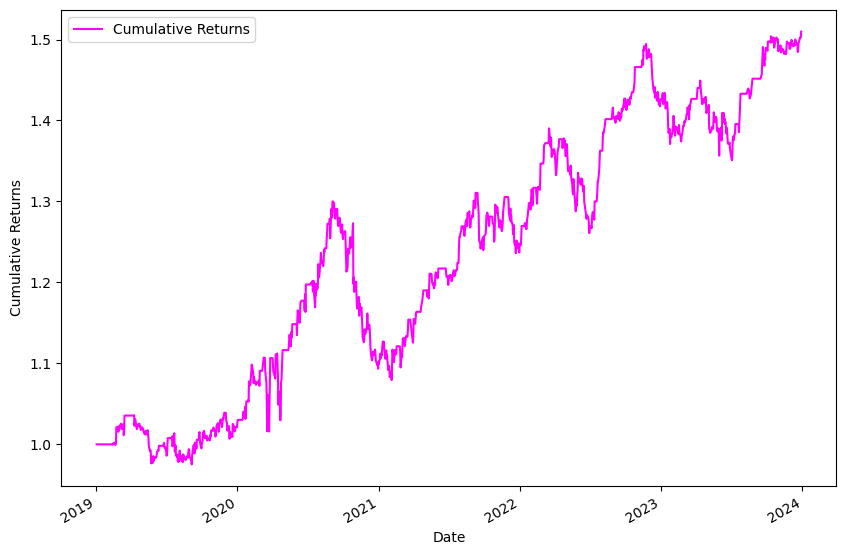

In [13]:
# Calculate percentage change in the spread
df['percentage_change'] = (df['Spread'] - df['Spread'].shift(1)) / (hr * df['HDFCBANK'] + df['KOTAKBANK'])
# Strategy returns: based on the positions and percentage change in the spread
df['strategy_returns'] = df['positions'].shift(1) * df['percentage_change']

# Calculate cumulative returns
df['cumulative_returns'] = (df['strategy_returns'] + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 7))
df['cumulative_returns'].plot(label='Cumulative Returns', color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [14]:
sharpe_ratio = (df['strategy_returns'].mean() * 252) / (df['strategy_returns'].std() * np.sqrt(252))
print(f'Sharpe Ratio: {np.round(sharpe_ratio, 3)}')


Sharpe Ratio: 0.78


In [15]:
for period in [10, 20, 30, 40, 50, 60]:
    for std_dev in [0.5, 1, 1.5, 2]:
        df = mean_reversion_strategy(df, period, std_dev)
        df['strategy_returns'] = df['positions'].shift(1) * df['percentage_change']
        sharpe_ratio = (df['strategy_returns'].mean() * 252) / (df['strategy_returns'].std() * np.sqrt(252))
        print(f"Period: {period}, Std Dev: {std_dev}, Sharpe Ratio: {np.round(sharpe_ratio, 3)}")


Rolling stats (first 30 rows):
             moving_average  moving_std_dev  upper_band  lower_band
Date                                                              
2019-01-01             NaN             NaN         NaN         NaN
2019-01-02             NaN             NaN         NaN         NaN
2019-01-03             NaN             NaN         NaN         NaN
2019-01-04             NaN             NaN         NaN         NaN
2019-01-07             NaN             NaN         NaN         NaN
2019-01-08             NaN             NaN         NaN         NaN
2019-01-09             NaN             NaN         NaN         NaN
2019-01-10             NaN             NaN         NaN         NaN
2019-01-11             NaN             NaN         NaN         NaN
2019-01-14      374.468049        9.483181  379.209640  369.726458
2019-01-15      371.834928       11.778575  377.724216  365.945640
2019-01-16      368.398790       14.979243  375.888412  360.909169
2019-01-17      366.045819    

In [16]:
# Drawdown Analysis
df['cumulative_max'] = df['cumulative_returns'].cummax()
df['drawdown'] = (df['cumulative_returns'] - df['cumulative_max']) / df['cumulative_max']
max_drawdown = df['drawdown'].min()
print(f"Max Drawdown: {np.round(max_drawdown * 100, 2)}%")


Max Drawdown: -16.97%


Drawdown Analysis

Maximum drawdown: -16.97%


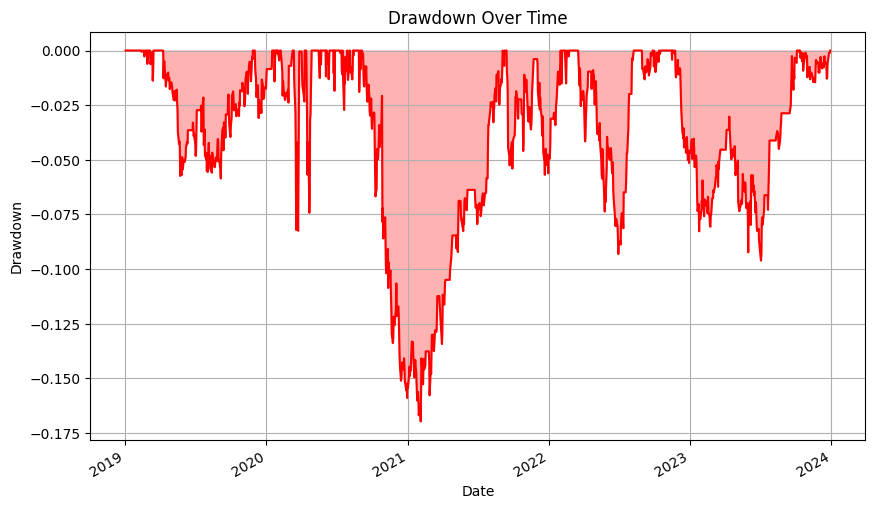

In [17]:
# Drawdown Analysis
# Function to calculate drawdown
def calc_drawdown(cum_rets):
    running_max = np.maximum.accumulate(cum_rets.dropna())
    drawdown = cum_rets / running_max - 1
    return drawdown

# Function to plot drawdown
def plot_drawdown(drawdown):
    drawdown.plot(color='red', figsize=(10, 6))
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.ylabel('Drawdown')
    plt.title('Drawdown Over Time')
    plt.grid(True)
    plt.show()

# Calculate drawdown for the strategy
drawdown_strategy = calc_drawdown(df['cumulative_returns'])

# Print maximum drawdown
print("Maximum drawdown: {:.2f}%".format(drawdown_strategy.min() * 100))

# Plot the drawdown
plot_drawdown(drawdown_strategy)


Strategy Comparison with NIFTY

[*********************100%%**********************]  1 of 1 completed


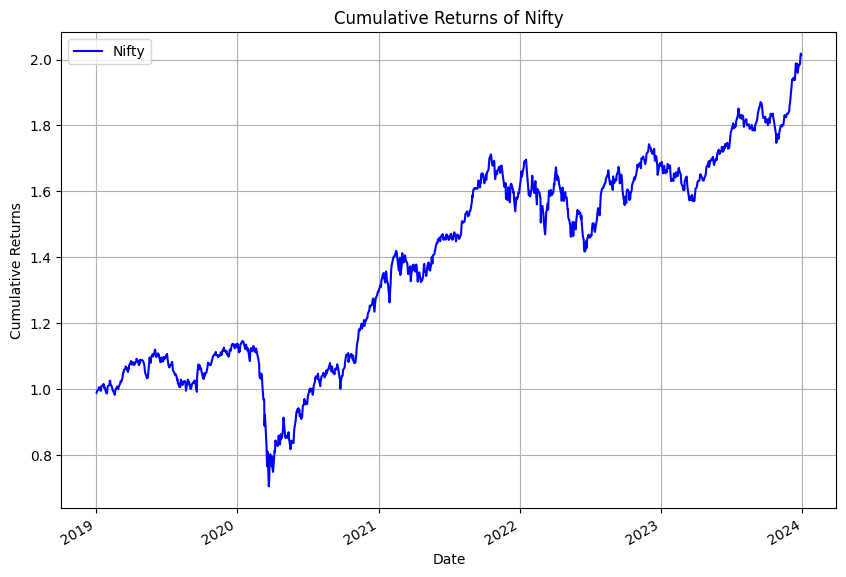

Maximum Nifty drawdown: -38.44%


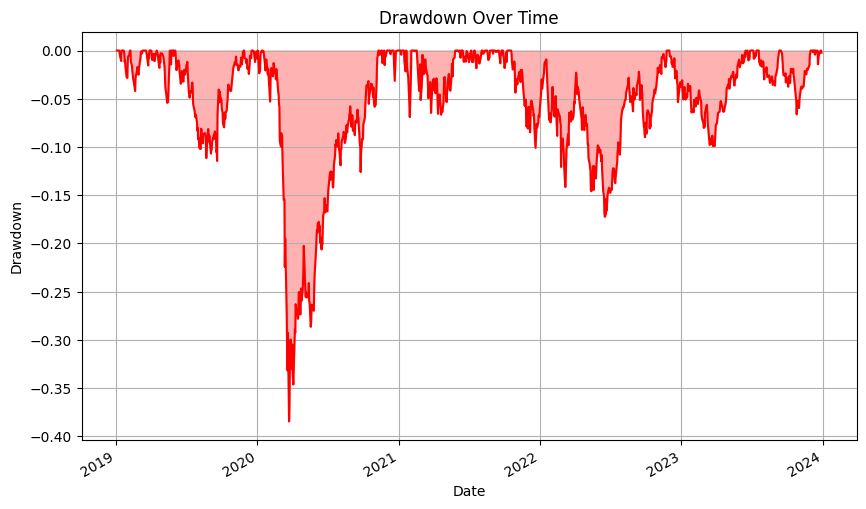

In [18]:
enddate='2023-12-31'
startdate='2019-1-1'
start_date = pd.to_datetime(startdate)
end_date = pd.to_datetime(enddate)

# Downloading Nifty data from Yahoo Finance
nifty = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Calculate cumulative returns
nifty_cum_rets = (nifty.pct_change().dropna() + 1).cumprod()

# Plotting cumulative returns of Nifty
plt.figure(figsize=(10, 7))
nifty_cum_rets.plot(label='Nifty', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Nifty')
plt.legend()
plt.grid(True)
plt.show()

# Calculating Nifty drawdown
def calc_drawdown(cum_rets):
    running_max = cum_rets.cummax()
    drawdown = (cum_rets - running_max) / running_max
    return drawdown

def plot_drawdown(drawdown):
    drawdown.plot(color='red', figsize=(10, 6))
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.ylabel('Drawdown')
    plt.title('Drawdown Over Time')
    plt.grid(True)
    plt.show()

drawdown_nifty = calc_drawdown(nifty_cum_rets)

# Print maximum drawdown
print("Maximum Nifty drawdown: {:.2f}%".format(drawdown_nifty.min() * 100))

# Plot the Nifty drawdown
plot_drawdown(drawdown_nifty)